In [73]:
#from pathlib import Path

import glob
import altair as alt
import pandas as pd

In [74]:
colo829bl_10x = pd.read_csv("../data/processed/COLO829BL-10X-hg38.hist.csv")
colo829t_10x = pd.read_csv("../data/processed/COLO829T-10X-hg38.hist.csv")
colo829bl = pd.read_csv("../data/processed/COLO829BL-hg38.hist.csv")
colo829t = pd.read_csv("../data/processed/COLO829T-hg38.hist.csv")

colo829bl_10x['color'] = 1
colo829t_10x['color'] = 2
colo829bl['color'] = 3
colo829t['color'] = 4

datasets = [colo829bl_10x, colo829t_10x, colo829bl, colo829t]

In [ ]:
colo829t.sort_values('chromosome', ascending=['chr'+str(x) for x in range(1,22)].append('chrX'))

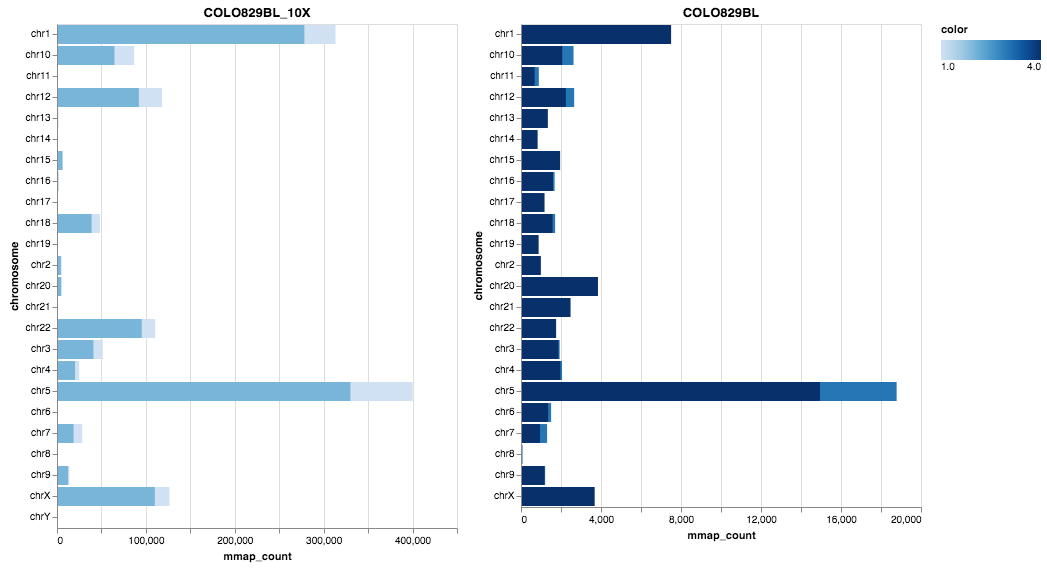

In [75]:
charts = []

for ds in datasets:
    charts.append(alt.Chart(ds).mark_bar().encode(
        x = 'mmap_count',
        y = 'chromosome',
        color = 'color'
    ))

charts[0].title = "COLO829BL_10X"
charts[1].title = "COLO829T_10X"
charts[2].title = "COLO829BL"
charts[3].title = "COLO829T"

# Titles will not concatenate when Layering plots like I do here with 10x vs Truseq.
# This is, I think, because bugs in vega-lite merged in March not yet upstreamed: https://github.com/altair-viz/altair/issues/585 and https://github.com/vega/vega-lite/pull/3620
(charts[0] + charts[1]) | (charts[2] + charts[3])